# Imports and initialization

#### Imports

In [1]:
import torch
from model import VAE
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torchvision.transforms as transforms
from tqdm import tqdm
from torchmetrics.image import TotalVariation
import torch.nn.functional as F
import gc


In [2]:
DEVICE = "cuda"

model = VAE().to(DEVICE)
model.load_state_dict(torch.load("train_results/model_weights_final.pth"))
to_tensor = torchvision.transforms.functional.to_tensor

dummy input shape  torch.Size([4096])


#### Plots

In [3]:
def plot_loss(loss):
    f,ax=plt.subplots(figsize=(5,3))
    plt.plot(loss)
    plt.suptitle("Optimization loss");

In [4]:
def plot_image(img):

    img = img[0].permute(1,2,0).detach().cpu()
    height, width, depth = img.shape

    figsize = width/64 , height/64
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    ax.imshow(img.numpy(), interpolation='nearest')


In [5]:
def plot_comparison(before, after, title):

    before = before[0].permute(1,2,0).detach().cpu()
    after  = after[0].permute(1,2,0).detach().cpu()

    f, axarr = plt.subplots(2)
    plt.suptitle(title)

    axarr[0].imshow(before)
    axarr[0].set_title("Before") 
    axarr[1].imshow(after)
    axarr[1].set_title("After") 
    axarr[0].axis('off')
    axarr[1].axis('off')

In [6]:
def plot_comparison_with_start(original, before, after, title):
    original = original[0].permute(1,2,0).detach().cpu()
    before = before[0].permute(1,2,0).detach().cpu()
    after  = after[0].permute(1,2,0).detach().cpu()

    f, axarr = plt.subplots(3)
    
    plt.suptitle(title)
    
    axarr[0].set_title("Input image") 
    axarr[0].imshow(original)
    axarr[0].axis('off')

    axarr[1].set_title("VAE Transformation") 
    axarr[1].imshow(before)
    axarr[1].axis('off')

    axarr[2].imshow(after)
    axarr[2].set_title("Final Output") 
    axarr[2].axis('off')

    for i in range(3):
        axarr[i].title.set_size(10)

In [7]:
def plot_comparison_with_history(original, before, after, title, history):
    original = original[0].permute(1,2,0).detach().cpu()
    before = before[0].permute(1,2,0).detach().cpu()
    after  = after[0].permute(1,2,0).detach().cpu()

    f, axarr = plt.subplots(3)
    
    plt.suptitle(title)
    
    axarr[0].set_title("Input image") 
    axarr[0].imshow(original)
    axarr[0].axis('off')

    axarr[1].set_title("VAE Transformation") 
    axarr[1].imshow(before)
    axarr[1].axis('off')

    axarr[2].imshow(after)
    axarr[2].set_title("Final Output") 
    axarr[2].axis('off')

    for i in range(3):
        axarr[i].title.set_size(10)

In [8]:
def plot_comparison_with_history(original, before, after, title, history):
    original = original[0].permute(1, 2, 0).detach().cpu()
    before = before[0].permute(1, 2, 0).detach().cpu()
    after = after[0].permute(1, 2, 0).detach().cpu()

    f, axarr = plt.subplots(2, 2, figsize=(8, 6))

    plt.suptitle(title)

    axarr[0, 0].set_title("Input image")
    axarr[0, 0].imshow(original)
    axarr[0, 0].axis('off')

    axarr[0, 1].set_title("VAE Transformation")
    axarr[0, 1].imshow(before)
    axarr[0, 1].axis('off')

    axarr[1, 0].imshow(after)
    axarr[1, 0].set_title("Final Output")
    axarr[1, 0].axis('off')

    axarr[1, 1].plot(history) 
    axarr[1, 1].set_title("Optimization Loss")
    axarr[1, 1].set_xlabel("Epoch")
    axarr[1, 1].set_ylabel("Loss")

    for i in range(2):
        for j in range(2):
            axarr[i, j].title.set_size(16)

    plt.tight_layout()
    plt.show()

In [9]:
def plot_before_after_with_history(before, after, title, history):
    before = before[0].permute(1, 2, 0).detach().cpu()
    after = after[0].permute(1, 2, 0).detach().cpu()
    empty = torch.ones_like(after).detach().cpu()

    f, axarr = plt.subplots(2, 2, figsize=(8, 6))

    plt.suptitle(title)

    axarr[0, 0].set_title("Input image")
    axarr[0, 0].imshow(before)
    axarr[0, 0].axis('off')

    axarr[0, 1].set_title("Final Output ")
    axarr[0, 1].imshow(after)
    axarr[0, 1].axis('off')

    axarr[1, 0].imshow(empty)
    axarr[1, 0].axis('off')

    axarr[1, 1].plot(history) 
    axarr[1, 1].set_title("Optimization Loss")
    axarr[1, 1].set_xlabel("Epoch")
    axarr[1, 1].set_ylabel("Loss")

    for i in range(2):
        for j in range(2):
            axarr[i, j].title.set_size(16)

    plt.tight_layout()
    plt.show()

In [10]:
transform_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

# VAE Inference demo

For this homework project, I created a simple toy VAE with the PolyHaven dataset, which learns to reconstruct given samples of environment maps. Then, I will use the VAE to optimize its latent code using the CLIP-based loss given a prompt. In addition to the traditional VAE losses, I added a CLIP-based loss using the fine-tuned model from clip_finetune.ipynb.
For the code of the VAE, the reference is at
- model.py
- train.py

Please note that the quality of the VAE may not be optimal, because more focus was given to experimenting with the CLIP-based optimization

In [11]:
x = to_tensor(Image.open("dataset/polyhaven_png_128/cannon_1k.png")).unsqueeze(0).to(DEVICE) #lenong_3_1k.png
print(x.shape)

torch.Size([1, 3, 128, 256])


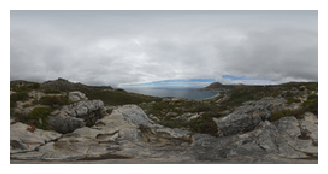

In [12]:
plot_image(x)

In [13]:
# Normalize x as intended for input in the VAE
x_norm = transform_normalize(x)

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


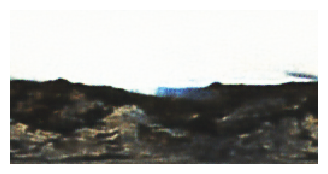

In [14]:
def full_inference(model, input):
    model.eval()
    with torch.no_grad():
            mu, sigma = model.encode(input)
            z = model.reparameterize(mu, sigma)
            output = model.decode(z)
            
    return output

y = full_inference(model, x_norm)

plot_image(y)

# CLIP loss

In [15]:

class CustomCLIPLoss(torch.nn.Module):

    def __init__(self, clip_model="ViT-B/32", checkpoint=None):#, resize=224):
        super(CustomCLIPLoss, self).__init__()
        self.model, clip_preprocess = clip.load(clip_model, device="cuda", jit=False)
        self.model.eval()

        if checkpoint is not None:
            # source: https://github.com/openai/CLIP/issues/83
            ckpt = torch.load(checkpoint)
            self.model.load_state_dict(ckpt)
    
        # Remove from the CLIP preprocessor the PIL related operations
        self.preprocess = transforms.Compose([
                clip_preprocess.transforms[0],
                clip_preprocess.transforms[1],
                clip_preprocess.transforms[4]
        ])

    def forward(self, image, text, crop=True):
        image = self.preprocess(image) 
        
        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(text)
        
        similarity = torch.nn.functional.cosine_similarity(image_features, text_features)

        return 1-similarity
    

    def similarity(self, image, text, crop=True):
        image = self.preprocess(image) 
        
        image_features = self.model.encode_image(image)
        text_features = self.model.encode_text(text)
        
        similarity = torch.nn.functional.cosine_similarity(image_features, text_features)

        return similarity
    

In [16]:
clip_loss = CustomCLIPLoss()

# CLIP optimization

In [17]:
def get_optimizer(var, lr, weight_decay=0):
    var_optim = var.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([var_optim], lr=lr, weight_decay=weight_decay)
    return var_optim, optimizer

## Optimization on plain pixels

In this example, I show that optimizing on plain pixels is not enough: the sparsity nature of the problems makes it impossible for the optimizer to reconstruct what is given in the prompt, resulting in a noisy image

In [18]:
img_optim, optimizer = get_optimizer(x, lr=1e-3, weight_decay=1e-5)

In [19]:
prompt= "a sunset environment, nature scene with clear sky, scenic sun"
text = clip.tokenize(prompt).to(device="cuda")

history=[]

loop = tqdm(range(1000))

for it in loop:

    loss_clip = clip_loss(img_optim, text)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history.append(loss.item())
    loop.set_postfix(loss=loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1000/1000 [00:50<00:00, 19.83it/s, loss=0.13]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


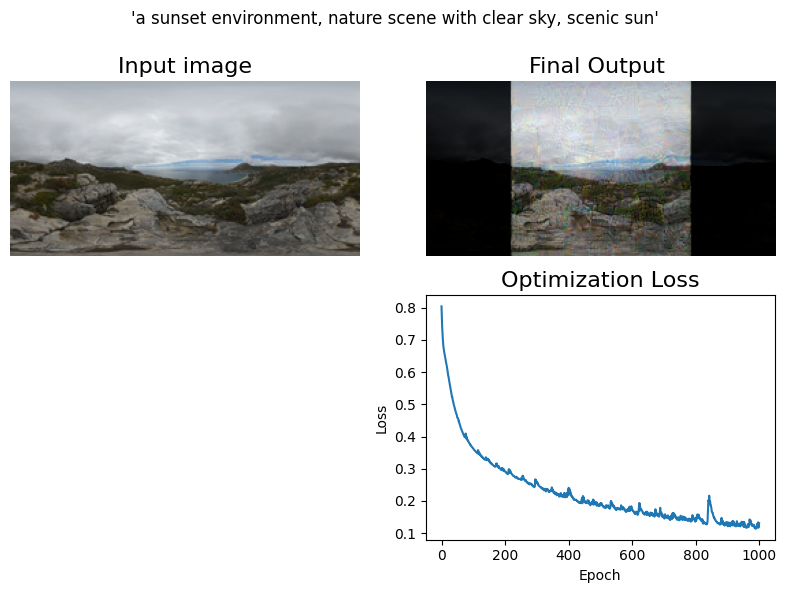

In [20]:
plot_before_after_with_history(x, img_optim, title="'{}'".format(prompt), history=history)

# Optimization on latent space

By optimizing the latent code of the VAE, the optimizer is able to approach the target prompt, because the decoder has knowledge of the domain and it's able to reconstruct samples from the modified latent code.
In this case, the goal of the inversion problem is:

- "Given a textual input, what is the latent code such that the decoded image resembles the CLIP embedding of the prompt?"


### Optimizers initialization

Fully Connected

In [22]:
def decode_z(model, z):
    model.eval()

    mu, sigma = model.get_mu_logvar(z)
    z_rep = model.reparameterize(mu, sigma)
    
    output = model.decode(z_rep)
    return output

Mu Logvar

In [23]:
import torch.nn as nn
class LatentParameters(nn.Module):
    def __init__(self, mu, logvar):
        super(LatentParameters, self).__init__()
        self.mu = nn.Parameter(mu.clone().detach().requires_grad_(True))
        self.logvar = nn.Parameter(logvar.clone().detach().requires_grad_(True))

In [24]:
def decode_mu_logvar(model, mu, sigma):
    model.eval()
    z_rep = model.reparameterize(mu, sigma)
    output = model.decode(z_rep)
    return output

In [25]:
def get_optimizer_distrib(mu, logvar, lr, weight_decay=0):
    parameters = LatentParameters(mu, logvar)
    optimizer = torch.optim.Adam(parameters.parameters(), lr=lr, weight_decay=weight_decay)
    return parameters, optimizer

### Optimization function

In [26]:
def clip_latent_optimize(input, prompt, vae_model, clip_loss, optim_type="fc", n_iter=1600, tv = 0, kl = 0, lr=0.01, weight_decay=1e-3):

    # Variable for the transformed image
    tf_img = None

    # Preprocess the text with CLIP
    text = clip.tokenize(prompt).to(device="cuda")

    # Initialize the regularizers if needed
    tv_loss = TotalVariation().to(DEVICE) if tv > 0 else None
    kl_loss = nn.KLDivLoss(reduction="batchmean").to(DEVICE) if kl > 0 else None

    history=[]

    if optim_type == "fc":
        '''
            Fully Connected optimization: optimize on the latent code Z 
            (after the fully connected output of the VAE's encoder) 
            before it is transformed into Mu and Logvar
        '''
        
        z = model.encode_only(input) 
        z_optim, optimizer = get_optimizer(z, lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

        loop = tqdm(range(n_iter))
        for it in loop:
            tf_img = decode_z(vae_model, z_optim)

            loss_clip = clip_loss(tf_img, text)
            loss_tv = tv * tv_loss(tf_img) if tv>0 else 0

            if kl>0:
                kl_input = F.log_softmax(tf_img)
                kl_target = F.log_softmax(input)
                loss_kl = kl * kl_loss(kl_input, kl_target)

            else:
                loss_kl = 0

            loss = loss_clip + loss_tv + loss_kl
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loop.set_postfix(loss=loss.item(), loss_clip=loss_clip.item(), loss_tv=tv_loss)
            history.append(loss.cpu().item())

        output = decode_z(vae_model, z_optim)

    elif optim_type == "mu_logvar":
        '''
            Mu Logvar optimization: optimize directly on the parameters 
            of the Gaussian distribution of the VAE
        '''
    
        mu, logvar = model.encode(input)
        parameters_optim, optimizer = get_optimizer_distrib(mu, logvar, lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

        loop = tqdm(range(n_iter))
        for it in loop:
            tf_img = decode_mu_logvar(vae_model, parameters_optim.mu, parameters_optim.logvar)

            loss_clip = clip_loss(tf_img, text)
            loss_tv = tv * tv_loss(tf_img) if tv > 0 else 0

            if kl>0:
                kl_input = F.log_softmax(tf_img)
                kl_target = F.log_softmax(input)
                loss_kl = kl * kl_loss(kl_input, kl_target)

            else:
                loss_kl = 0


            loss = loss_clip + loss_tv + loss_kl

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loop.set_postfix(loss=loss.item(), loss_clip=loss_clip.item(), loss_tv=loss_tv)
            history.append(loss.cpu().item())

        output = decode_mu_logvar(vae_model, parameters_optim.mu, parameters_optim.logvar)

    else: 
        raise ValueError('Accepted optim_type: fc or mu_logvar')

    final_cos_sim = clip_loss.similarity(tf_img, text).cpu()

    return output.cpu(), history, final_cos_sim

Running the first optimization

In [27]:
loss_clip

tensor([0.1304], device='cuda:0', dtype=torch.float16, grad_fn=<RsubBackward1>)

In [28]:
prompt= "a sunset environment, nature scene with clear sky, scenic sun"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="fc", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [01:00<00:00, 16.45it/s, loss=0.704, loss_clip=0.699, loss_tv=TotalVariation()]


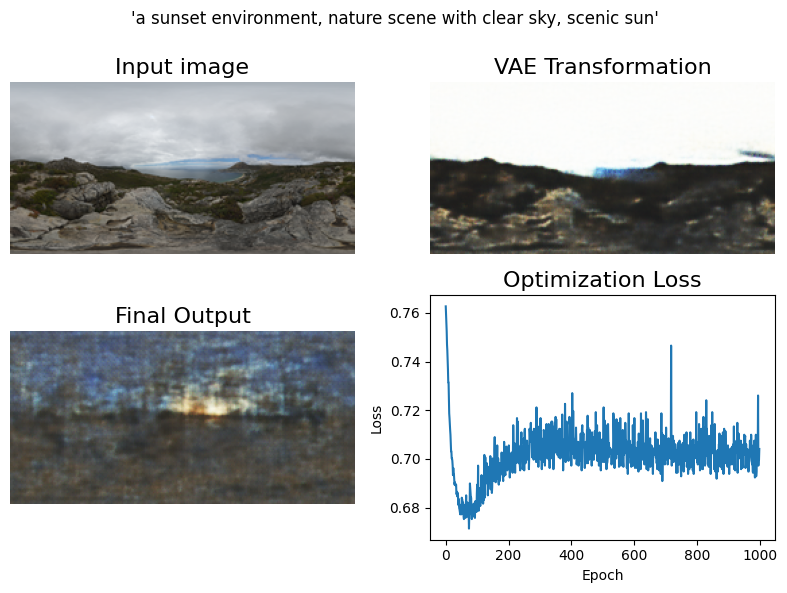

In [29]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)


## Optimization with fine-tuned CLIP

Inside clip_finetuning.ipynb, I finetuned the CLIP model using as captions the tags of the environment maps in the PolyHaven dataset. The following is a test with the fine-tuned model.
The model was fine-tuned with two types of images, using the PolyHaven metadata (tags, categories) as captions: 
- Plain PolyHaven environment maps
- The output of the VAE

### PolyHaven model

In [31]:
clip_loss = None
gc.collect()
torch.cuda.empty_cache()

clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")


In [32]:
prompt= "a sunset environment, nature scene with clear sky, scenic sun"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="fc", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [01:01<00:00, 16.30it/s, loss=0.646, loss_clip=0.641, loss_tv=TotalVariation()]


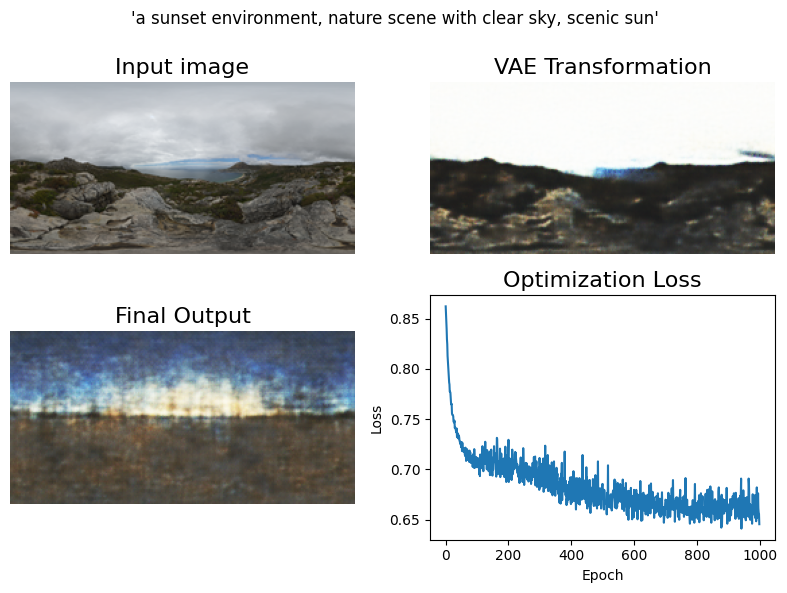

In [33]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)

### VAE model

In [35]:
clip_loss = None
gc.collect()
torch.cuda.empty_cache()

clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")

In [36]:
prompt = "a sunset environment, nature scene with clear sky, scenic sun"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="fc", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [01:01<00:00, 16.33it/s, loss=0.674, loss_clip=0.669, loss_tv=TotalVariation()]


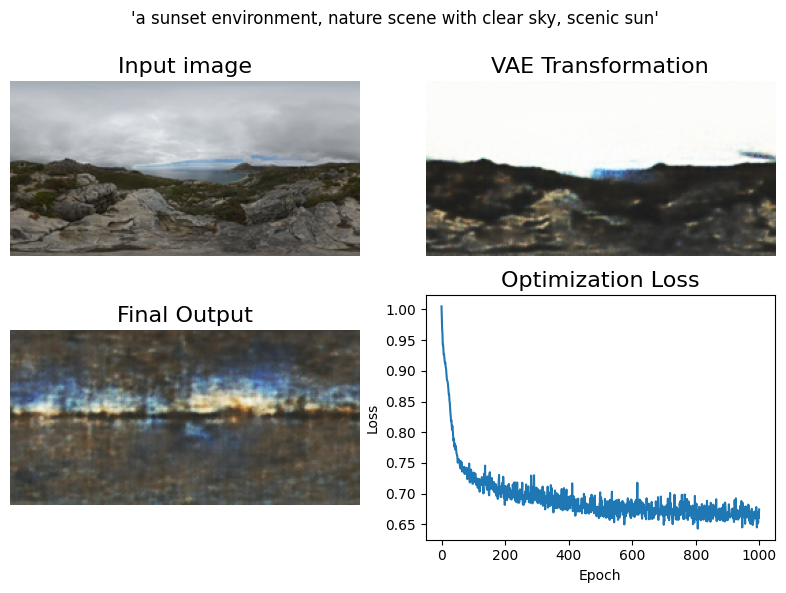

In [37]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)

#### More prompts with the CLIP-Polyhaven finetuned model

The results above and the evaluation in clip_finetune_evaluation.ipynb show that the CLIP-Polyhaven finetuned has the best performance.

Also, optimizing after the fully connected layer instead of mu-log var shows more understanding of the prompt.

The examples below are generated for the report.

In [39]:
clip_loss = None
gc.collect()
torch.cuda.empty_cache()

clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")

In [40]:
prompt = "dark environment, at night time, with trees in a forest"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="fc", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s, loss=0.57, loss_clip=0.566, loss_tv=TotalVariation()]


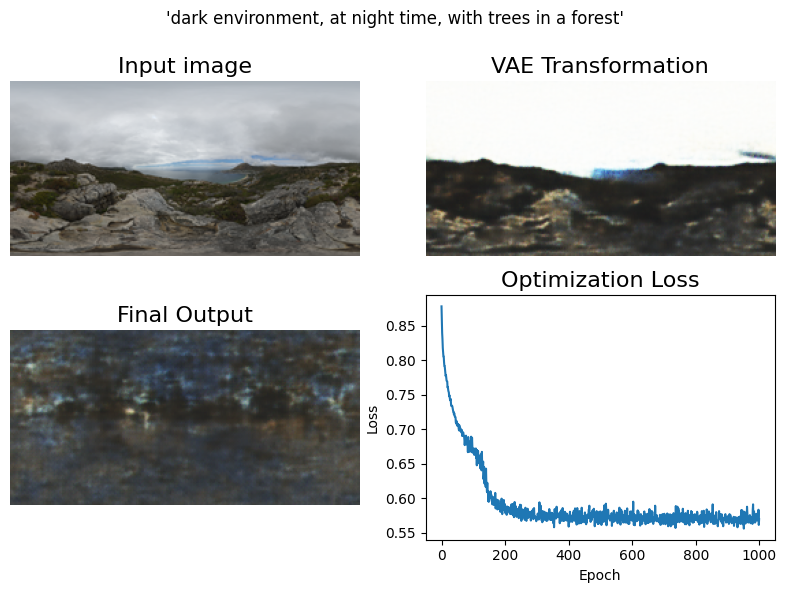

In [41]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)

#### Failure caises

Inability to reconstruct an indoor scene properly

In [43]:
prompt = "an indoor scene of a hangar"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="fc", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s, loss=0.77, loss_clip=0.764, loss_tv=TotalVariation()]


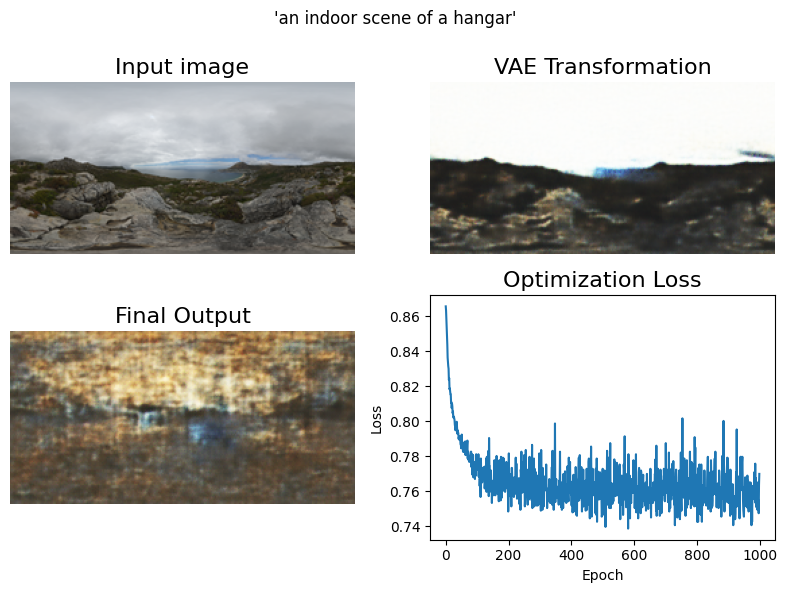

In [44]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)

The dark environment prompt with the Mu Logvar optimization

shows inability to match the textual target

In [46]:
clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")

prompt = "dark environment, at night time, with trees in a forest"
output, history, cos_sim = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=1000, optim_type="mu_logvar", tv=1e-6, kl=0, lr=0.01, weight_decay=1e-3)

100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s, loss=0.717, loss_clip=0.712, loss_tv=tensor(0.0048, device='cuda:0', grad_fn=<MulBackward0>)]


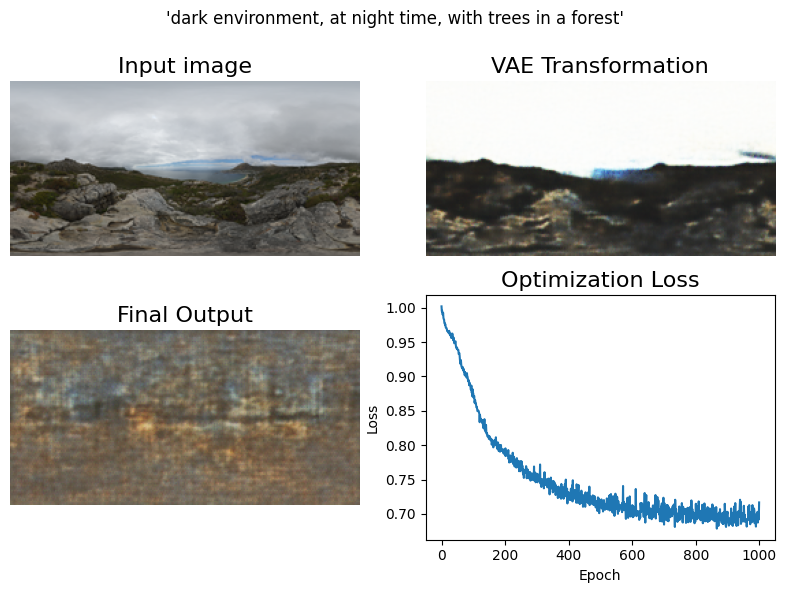

In [47]:
plot_comparison_with_history(x, y, output, title="'{}'".format(prompt), history=history)